# An Analysis of the Impact of COVID-19 on Crime in College Park, MD

### By Moses Kang, Andrew Xu, and Murat Ablimit

## Introduction

The COVID-19 pandemic has truly served as a transformative historical event in the 21st century. The pandemic has led to the dramatic loss of human life around the world. Additionally, many aspects of life and human behavior have been forced to change due to the restrictions and limitations COVID-19 has brought forth. The food service industry, retail, educational institutions, and healthcare have all been challenged and threatened enourmously. Periodic lockdowns and enforced quarantines have resulted in loss of income, economic assests, and employment in general for millions. When livelihoods become endangered to the extent like they have in this pandemic, immense feelings of desperation and hopelessness become frequent. For this reason, it becomes worthwhile to ask if this pandemic and all of its challenges have impacted criminal activitiy.    

In this project, we will attempt to present and uncover a correlation between the pandemic and criminal activity in the city of College Park, Maryland. We will do so by analyzing crime data between two time periods. The first time period being the entire year of 2019 to March 2020 (pre-pandemic), and the second time period being April of 2020 onwards (pandemic).     

## Data Collection

To collect the neccessary data for this project, we will scrape the University of Maryland, College Park Police Department website: http://www.umpd.umd.edu/stats/incident_logs.cfm. Because the website organizes the data by year and month, we will use python's requests module to retrieve the HTML that corresponds to the page for each month in a year. Afterwards, we will use the BeautifulSoup library to to find the html for the table that contains the data for each month. We will then concatenate each month's data to make a dataframe for each year. Because we are comparing crime between pre-pandemic and during the pandemic, we will only use the data from 2019 to 2020. Yearly data is then stored in a dictionary, with the year (2019 or 2020) acting as the key and the corresponding dataframes for each year serving as the values.  



In [74]:
import requests
import pandas as pd, numpy as np, sklearn as sk, matplotlib.pyplot as plt
from sklearn import linear_model
from bs4 import BeautifulSoup
from scipy.stats import ttest_rel
import sys
!{sys.executable} -m pip install lxml html5lib

In [2]:
years = ['2019','2020']

#Dictionary that will hold the data
data_raw = {}

#Loops for each year
for year in years:
    
    #This will hold each yearly data set
    df = pd.DataFrame()
    
    #Loops for each month
    for m in range(1,13):
        page = requests.get('http://www.umpd.umd.edu/stats/incident_logs.cfm?year='+year+"&month="+str(m))
        content = BeautifulSoup(page.content)
        table = content.find('table')
        t = pd.read_html(str(table))
        d=pd.concat(t)
        df = pd.concat([df,d])
        
    #adds the yearly data to the main dictionary
    data_raw[year] = df
    
data_raw['2019'].head()

,UMPD CASENUMBER,OCCURRED DATE TIMELOCATION,REPORT DATE TIME,TYPE,DISPOSITION,Unnamed: 5
0,2019-00000001,01/01/19 00:01,01/01/19 00:01,Fireworks Complaint,Arrest,NaN
1,2019-00000001,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd,4300 block of Knox Rd
2,2019-00000009,01/01/19 01:20,01/01/19 01:20,DWI/DUI,Arrest,NaN
3,2019-00000009,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave,8300 block of Baltimore Ave
4,2019-00000011,01/01/19 01:28,01/01/19 01:28,DWI/DUI,Arrest,NaN


## Data Processing

As can be seen above, data scraping does not give ideally formatted or "clean" data, due to how the website and html stores data. The main problem is that each case is listed twice in the dataframe, with the location of the case being listed 5 times in the 2nd entry and there being a column named "Unnamed: 5". Additonally, the way we have divided our data in terms of year does not really make sense either. We have two dataframes for crime data for 2019 and 2020, since we want to be comparing data pre-pandemic and during the pandemic, it makes more sense if we change these two dataframes so that they reflect the actual periods of time that constitute life before the pandemic and life during the pandemic. For the purposes of this project, we are going to consider 2019 to before March 2020 as pre-pandemic and March 2020 onwards as the pandemic. In this section we will tidy up the data, reformat it for our convenience, and deal with all NaN or missing values.

In [3]:
data_cleaned = {}

for year in years:
    i = 0
    df_new = pd.DataFrame(columns = ['CaseNumber', 'OccuredDateTime','ReportDateTime', 'Type', 'Disposition', 'Location'])

    while i < len(data_raw[year]):
    
        df_new = df_new.append({'CaseNumber' : data_raw[year].iloc[i]['UMPD CASENUMBER'],
                                'OccuredDateTime' : data_raw[year].iloc[i]['OCCURRED DATE TIMELOCATION'],
                                'ReportDateTime' : data_raw[year].iloc[i]['REPORT DATE TIME'],
                                'Type' : data_raw[year].iloc[i]['TYPE'],
                                'Disposition' : data_raw[year].iloc[i]['DISPOSITION'],
                                'Location' : data_raw[year].iloc[i+1]['OCCURRED DATE TIMELOCATION']}, ignore_index=True)
        i+=2
    data_cleaned[year] = df_new
    

data_cleaned['2019'].head()

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
0,2019-00000001,01/01/19 00:01,01/01/19 00:01,Fireworks Complaint,Arrest,4300 block of Knox Rd
1,2019-00000009,01/01/19 01:20,01/01/19 01:20,DWI/DUI,Arrest,8300 block of Baltimore Ave
2,2019-00000011,01/01/19 01:28,01/01/19 01:28,DWI/DUI,Arrest,7400 block of Baltimore Ave
3,2019-00000203,12/28/18 17:00,01/02/19 11:34,Vandalism,CBE,7500 block of Calvert Service Ln
4,2019-00000312,01/02/19 23:04,01/02/19 23:04,CDS Violation,Arrest,Metzerott Rd


In summary, instead of modifying each dataframe, we opted to create a new dataframe for each year, as this approach was simpler to code. Essentially, we have removed every other row and replaced the unnamed column with the location of the incident, as well as renaming each column header.

After this data cleaning process, we now need to split this clean data into the appropriate time periods, pre-pandemic and pandemic, for our analysis. The below code will accomplish this.

As described before, pre-pandemic will constitute 2019 to March 2020 and the pandemic will constitute March 2020 onwards. Therefore, we need to split the 2020 dataframe in the data_cleaned dictionary at the first case that occured in March. We then need to append all the cases that occured in 2020 but before March 2020 to the 2019 crime data dataframe (represented as data_cleaned['2019']). 

In [4]:
data_to_analyze = {} #store the final processed data into this dictionary

for index, row in data_cleaned['2020'].iterrows():
    if row['OccuredDateTime'].startswith('03'): #finds the first case that occured in March of 2020
        pre_pandemic_2020 = data_cleaned['2020'].iloc[:index,:] #dataframe that has cases before March 2020
        pandemic_2020 = data_cleaned['2020'].iloc[index + 1:,:] #dataframe that has cases from March 2020 onwards
        break
        

data_to_analyze['pre_pandemic'] = data_cleaned['2019'].append(pre_pandemic_2020) #crime data for 2019 to March 2020
data_to_analyze['pandemic'] = pandemic_2020 #crime data for March 2020 onwards
data_to_analyze['pandemic']

,CaseNumber,OccuredDateTime,ReportDateTime,Type,Disposition,Location
261,2020-00015628,03/01/20 01:53,03/01/20 01:53,Injured/Sick Person,CBE,3900 block of Campus Dr
262,2020-00015635,03/01/20 02:20,03/01/20 02:20,Disorderly Conduct,Arrest,7300 block of Baltimore Ave
263,2020-00015636,03/01/20 02:25,03/01/20 02:28,Disorderly Conduct,Arrest,4400 block of Knox Rd
264,2020-00015637,03/01/20 02:30,03/01/20 02:30,Suspicious Activity,Arrest,7500 block of Baltimore Ave
265,2020-00015661,03/01/20 04:11,03/01/20 04:11,Assist Other Agency / Check on the Welfare,CBE,8300 block of Baltimore Ave
...,...,...,...,...,...,...
905,2020-00089196,12/13/20 00:02,12/13/20 00:02,CDS Violation,Arrest,Baltimore Ave
906,2020-00089210,12/13/20 03:49,12/13/20 03:49,Trespassing,CBE,Stadium Dr / Farm Dr
907,2020-00089949,12/11/20 21:00,12/15/20 17:47,Theft from Auto,Active/Pending,8300 block of Boteler Ln
908,2020-00089984,12/15/20 21:40,12/15/20 21:40,Trespassing,CBE,NaN


## Exploratory Analysis and Data Visualization

## Analysis & Hypothesis Testing

In this section, we'll be looking at the data from the crime rate in College Park, Maryland in the years of 2019 and 2020. We'll gather the amount of violations each month and then compare them to see if there's any difference between pre-COVID and post-COVID with violations.

In [21]:
## Copy created to not mess with inital DF
data19 = data_cleaned['2019'].copy()
## Have to change to datetime format for pandas to split by month
data19["ReportDateTime"] = pd.to_datetime(data19["ReportDateTime"]) 

## Grouping by the type of violation and getting the count of the number of violations per month in 2019
count19 = pd.DataFrame(data19.groupby([pd.Grouper(key = 'ReportDateTime', freq = 'M')])['ReportDateTime'].transform('size')).drop_duplicates()
count19.columns = {'Num_Of_Violations'}
count19

,Num_Of_Violations
0,94
94,166
260,152
412,189
601,199
800,98
898,96
994,165
1159,234
1393,196


In [22]:
## Copy created to not mess with inital DF
data20 = data_cleaned['2020'].copy()
## Have to change to datetime format for pandas to split by month
data20["ReportDateTime"] = pd.to_datetime(data20["ReportDateTime"]) 

## Grouping by the type of violation and getting the count of the number of violations per month in 2020
count20 = pd.DataFrame(data20.groupby([pd.Grouper(key = 'ReportDateTime', freq = 'M')])['ReportDateTime'].transform('size')).drop_duplicates()
count20.columns = {'Num_Of_Violations'}
count20

,Num_Of_Violations
0,106
106,154
260,113
373,28
401,37
438,21
459,33
492,67
559,119
678,124


Since the indexes of both tables are in ascending order (starting at 0), we can assume each index marks a new month. i.e. in 2020, 0 is Janurary, 106 is Feburary, 260 is March, etc. So, we'll add the monthly values in order accordingly. (i.e Janurary = 1, Feburary = 2, etc).

In [23]:
count19['Month'] = np.arange(len(count19))
count19['Month'] += 1
count19

,Num_Of_Violations,Month
0,94,1
94,166,2
260,152,3
412,189,4
601,199,5
800,98,6
898,96,7
994,165,8
1159,234,9
1393,196,10


In [24]:
count20['Month'] = np.arange(len(count20))
count20['Month'] += 1
count20

,Num_Of_Violations,Month
0,106,1
106,154,2
260,113,3
373,28,4
401,37,5
438,21,6
459,33,7
492,67,8
559,119,9
678,124,10


Initially comparing the data in 2019 and 2020, we see that violations in Janurary and Feburary are around the same between 2019 and 2020 with slight deviations. However, when we hit March, we see a decrease, all the way through pretty much the rest of the year.

Note that during this time, we do know that the number of students, staff, and faculty decreased on campus after students were sent home after March 12, 2020 and stay-at-home (virtual) learning began. This does decrease the number of people commuting to and residing within College Park (at least students living in dorms have decreased). Furthermore, since virtual learning continued throughout summer and fall semesters, we continue to see less students and staff on campus. With a siginificant amount of campus population being gone, it could contribute to the major decrase in violations in College Park. 

Let's take a quick closer looke at this:

According to this website: https://datausa.io/profile/geo/college-park-md/, we see that there's a population of 32,183. 

According to this website: https://www.usnews.com/best-colleges/university-of-maryland-2103/student-life, 39% of students live on campus.

39% of 40,743 total enrolled students is around 15,890 students on campus. Assuming that everyone went home because of the COVID-19 Pandemic, that's around 16,000 students that left the College Park area (assuming that students who live on campus don't live in College Park).

Now, let's do a linear regression for 2019 and 2020 and plot the number of violations each month in each year:

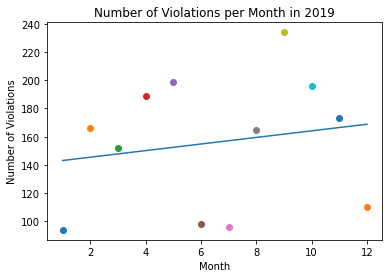

In [76]:
x19 = np.array(count19['Month']).reshape(-1,1)
y19 = np.array(count19['Num_Of_Violations']).reshape(-1,1)
reg19 = sk.linear_model.LinearRegression().fit(x19, y19)
plt.plot(x19, reg19.predict(x19))
plt.title('Number of Violations per Month in 2019')
plt.xlabel('Month')
plt.ylabel('Number of Violations')
for i, row in count19.iterrows():
    plt.scatter(row['Month'], row['Num_Of_Violations'])
plt.show()

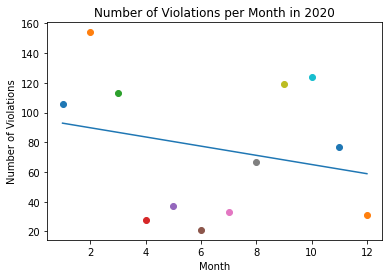

In [75]:
x20 = np.array(count20['Month']).reshape(-1,1)
y20 = np.array(count20['Num_Of_Violations']).reshape(-1,1)
reg20 = sk.linear_model.LinearRegression().fit(x20, y20)
plt.plot(x20, reg20.predict(x20))
plt.title('Number of Violations per Month in 2020')
plt.xlabel('Month')
plt.ylabel('Number of Violations')
for i, row in count20.iterrows():
    plt.scatter(row['Month'], row['Num_Of_Violations'])
plt.show()

After looking at the plot of violations per months for 2019 and 2020, we see that the number of violations per month incrases in 2019 (as seen in the linear regression in 2019) and the number of violations per month in 2020 decreases (as seen in the linear regression of 2020).

Continuing, we'll run a t-test based off the values of the linear regression from 2019 and 2020 and see if we reject or fail to reject the null hypothesis.

In [81]:
predict19 = reg19.predict(x19)
predict20 = reg20.predict(x20)
t1 = ttest_rel(predict19, y19)
t2 = ttest_rel(predict20, y20)
t3 = ttest_rel(predict19, predict20)
print(t1)
print(t2)
print(t3)

Ttest_relResult(statistic=array([1.07072527e-15]), pvalue=array([1.]))
Ttest_relResult(statistic=array([-1.01028991e-15]), pvalue=array([1.]))
Ttest_relResult(statistic=array([14.19342114]), pvalue=array([2.03626743e-08]))


As we can see from the t-test, the linear regression for 2019 works really well as the t value is extremely close to 0. The samse also occurs in 2020. Both of the first p-values are 1 meaning our linear regressions work really well with our data sets.

The last t-test compares the values in 2019 and 2020. As we can see, our t value is high at 14.19 with our p-value being really close to 0. Thus we fail to reject the null hypothesis, as our p-value is extremely low, we reject the null hypothesis as there is enough evidence to link the COVID-19 pandemic with a lower crime rate.